In [4]:
from pandas import DataFrame
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import random
from sklearn.preprocessing import StandardScaler
%matplotlib inline   
import matplotlib.pyplot as plt 
import seaborn as sns   
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [5]:
#data preprocessing
data=np.genfromtxt("shot_logs_modified.csv",delimiter=',')
print(np.isnan(data[3][1]))
print(np.shape(data))
print(len(data))

True
(128070, 8)
128070


In [6]:
data_DF=DataFrame(data, columns=["Period", "Shot_Clock", "Dribbles", "Touch_Time", "Shot_Distance", "Close_Def_Distance", "FGM", "Pts"])
data_DF=data_DF.fillna(0)
data_DF=data_DF[1:]
points = data_DF.pop("Pts")
data_DF.head()
print(data_DF.shape)
print(data_DF.columns)

(128069, 7)
Index(['Period', 'Shot_Clock', 'Dribbles', 'Touch_Time', 'Shot_Distance',
       'Close_Def_Distance', 'FGM'],
      dtype='object')


In [7]:
train, test = train_test_split(data_DF, test_size=0.15, random_state=1)
train, val = train_test_split(train, test_size=0.18, random_state=1)
train.shape, val.shape, test.shape

((89263, 7), (19595, 7), (19211, 7))

In [19]:
#standard model for validation
majority_class = train["FGM"].mode()[0]

y_pred = [majority_class] * len(test)

print("최빈 클래스: ", majority_class)
print("validation 데이터셋 정확도: ", accuracy_score(test["FGM"], y_pred))

최빈 클래스:  0.0
validation 데이터셋 정확도:  0.5483316849721513


In [9]:
#feature matrix 
corr = data_DF.corr(method = 'pearson')

<AxesSubplot:>

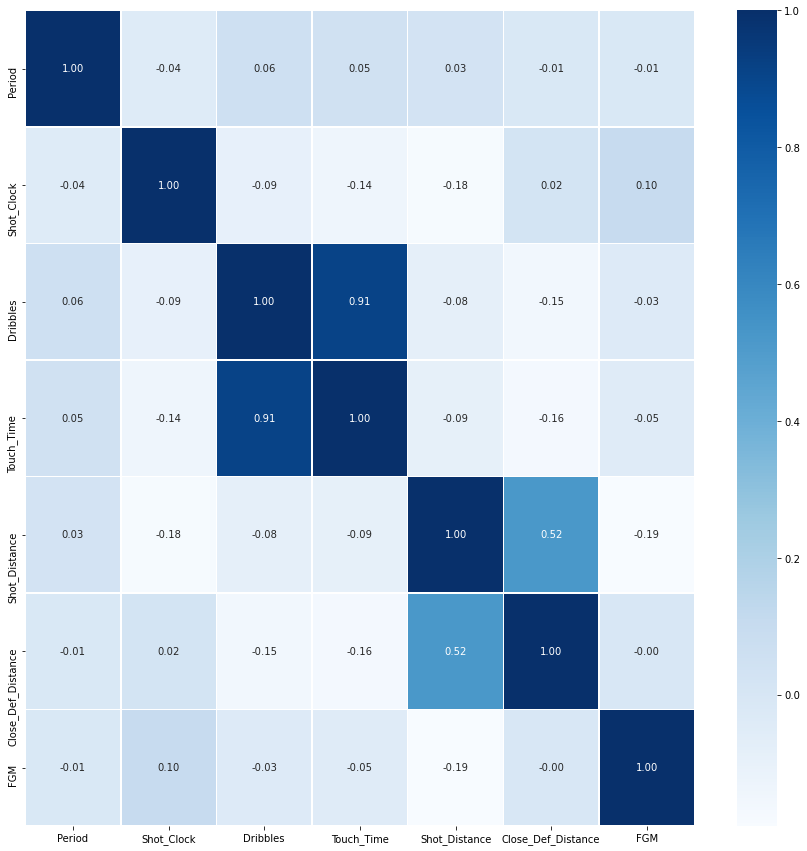

In [10]:
plt.figure(figsize=(15,15))
sns.heatmap(data = corr, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

#### Touch_Time - Dribbles has high coefficiency

# #1. Logistic Regression

In [11]:
feature = ["Period", "Shot_Clock", "Dribbles", "Shot_Distance", "Close_Def_Distance"]
target = "FGM"
print(feature)

X_train = train[feature]
y_train = train[target]

X_val = val[feature]
y_val = val[target]

X_test = test[feature]
y_test = test[target]

print("feature Matrix: ", X_train.shape, X_val.shape, X_test.shape)
print("target vector: ", y_train.shape, y_val.shape, y_test.shape)

['Period', 'Shot_Clock', 'Dribbles', 'Shot_Distance', 'Close_Def_Distance']
feature Matrix:  (89263, 5) (19595, 5) (19211, 5)
target vector:  (89263,) (19595,) (19211,)


In [12]:
#feature scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.T[0].mean(), X_train_scaled.std()

(1.2163038439683106e-16, 0.9999999999999999)

In [13]:
#model learning

logimodel = LogisticRegression()
logimodel.fit(X_train_scaled, y_train)

print("validation 데이터셋 정확도: ", logimodel.score(X_val_scaled, y_val))

validation 데이터셋 정확도:  0.611023220209237


In [14]:
#final learning

X_total = pd.concat([X_train, X_val])
y_total = pd.concat([y_train, y_val])

feature = ["Period", "Shot_Clock", "Dribbles", "Shot_Distance", "Close_Def_Distance"]
target = "FGM"

scaler = StandardScaler()

X_total_scaled = scaler.fit_transform(X_total)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_total_scaled, y_total)

print("test 데이터셋 정확도")
model.score(X_test_scaled, y_test)

test 데이터셋 정확도


0.6093383998750715

Close_Def_Distance    0.285479
Shot_Clock            0.112771
Period               -0.003396
Dribbles             -0.059590
Shot_Distance        -0.535595
dtype: float64


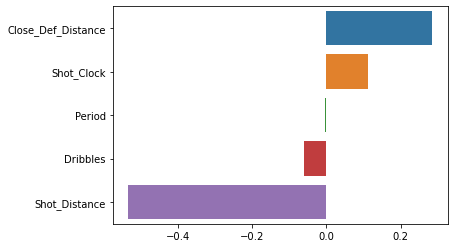

In [18]:
#feature coefficent

model_coef = pd.Series(model.coef_[0], feature).sort_values(ascending=False)
sns.barplot(x=model_coef, y=["Close_Def_Distance", "Shot_Clock", "Period", "Dribbles", "Shot_Distance"])
print(model_coef)
plt.show()

# #2. Random Forest (Decision Tree)

In [115]:
feature = ["Period", "Shot_Clock", "Touch_Time", "Shot_Distance", "Close_Def_Distance"]
target = "FGM"
print(feature)

X_train = train[feature]
y_train = train[target]

X_val = val[feature]
y_val = val[target]

X_test = test[feature]
y_test = test[target]

print("feature Matrix: ", X_train.shape, X_val.shape, X_test.shape)
print("target vector: ", y_train.shape, y_val.shape, y_test.shape)

['Period', 'Shot_Clock', 'Touch_Time', 'Shot_Distance', 'Close_Def_Distance']
feature Matrix:  (89263, 5) (19595, 5) (19211, 5)
target vector:  (89263,) (19595,) (19211,)


In [116]:
#feature scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.T[0].mean(), X_train_scaled.std()

(1.2163038439683106e-16, 0.9999999999999999)

In [117]:
rfmodel = RandomForestClassifier(random_state=0)
rfmodel.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=0)

In [118]:
print(rfmodel.score(X_val_scaled, y_val))

0.5867823424342945


In [119]:
rf_param_grid = {
    
    "n_estimators" : [100, 200, 300],
    "max_depth" : [6, 8, 10, 12],
    "min_samples_leaf" : [3, 5, 7, 10],
    "min_samples_split" : [2, 3, 5, 10]
    
}

In [120]:
#grid search
rf_gridsearch = GridSearchCV(rfmodel, rf_param_grid, scoring="accuracy", n_jobs=-1, verbose=1)
rf_gridsearch.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10, 12],
                         'min_samples_leaf': [3, 5, 7, 10],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [121]:
print(rf_gridsearch.best_score_)
print(rf_gridsearch.best_params_)

0.6206715449806
{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}


In [122]:
rf_gridsearch.score(X_val_scaled, y_val) 

0.6214850727226333

In [127]:
X_total = pd.concat([X_train, X_val])
y_total = pd.concat([y_train, y_val])

feature = ["Period", "Shot_Clock", "Dribbles", "Shot_Distance", "Close_Def_Distance"]
target = "FGM"

scaler = StandardScaler()

X_total_scaled = scaler.fit_transform(X_total)
X_test_scaled = scaler.transform(X_test)

rfmodel = RandomForestClassifier(n_estimators=200, max_depth=8, min_samples_split=2, min_samples_leaf=3, n_jobs=-1, verbose=1, random_state=0)
rfmodel.fit(X_total_scaled, y_total)

print("test 데이터셋 정확도")
rfmodel.score(X_test_scaled, y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


test 데이터셋 정확도


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


0.6207381187861121

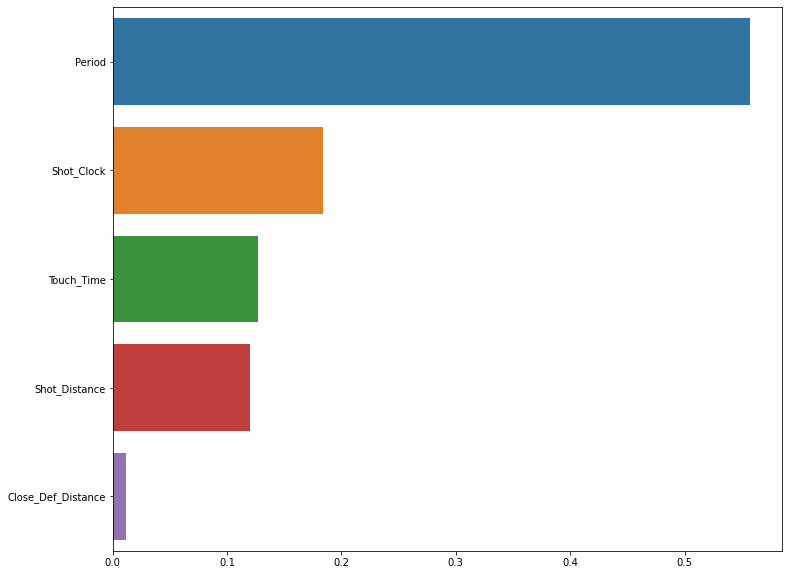

In [128]:
feature_imp = rfmodel.feature_importances_
ft_importance = pd.Series(feature_imp, index = X_total.columns)
ft_importance = ft_importance.sort_values(ascending=False)

plt.figure(figsize=(12,10))
sns.barplot(x=ft_importance, y=X_total.columns)
plt.show()